In [55]:
import json
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../Data/irctc/static_coverage.csv')

In [56]:
print(df.columns)

Index(['baseFare', 'reservationCharge', 'superfastCharge', 'fuelAmount',
       'totalConcession', 'tatkalFare', 'serviceTax', 'otherCharge',
       'cateringCharge', 'dynamicFare', 'totalFare', 'availability',
       'trainNumber', 'timeStamp', 'fromStnCode', 'toStnCode', 'classCode'],
      dtype='object')


In [57]:
# is total fare a total of all the different fares? Almost yes with a difference of max 4 rupees
sum_series = df[['baseFare', 'reservationCharge', 'superfastCharge', 'fuelAmount', 'totalConcession', 'tatkalFare', 'serviceTax', 'otherCharge', 'cateringCharge', 'dynamicFare']].sum(axis=1)
diff_series = df.totalFare-sum_series
diff_series.describe()

count    296055.000000
mean          0.005296
std           0.123749
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
dtype: float64

## FuelAmount, totalConcession, tatkalFare

In [58]:
df[['fuelAmount', 'totalConcession', 'tatkalFare']].value_counts()

fuelAmount  totalConcession  tatkalFare
0.0         0                0             296055
Name: count, dtype: int64

In [59]:
df.drop(['fuelAmount', 'totalConcession', 'tatkalFare'], axis=1, inplace=True)

## Other Charge

In [60]:
df[['otherCharge']].value_counts()

otherCharge
0              295110
15                630
25                315
Name: count, dtype: int64

In [61]:
# 01665 - AGTL FESTIVL SPL
# Only festival special trains have other charge which are minimal and irrelevant for our case as not much data for
# prediction
df[df.otherCharge>0][['otherCharge', 'trainNumber', 'totalFare']].groupby(['otherCharge', 'trainNumber']).count()

totalFare
otherCharge trainNumber           
15          1665               378
            1666               252
25          1665               189
            1666               126

In [62]:
df.drop(['otherCharge'], axis=1, inplace=True)

In [63]:
print(df.columns)

Index(['baseFare', 'reservationCharge', 'superfastCharge', 'serviceTax',
       'cateringCharge', 'dynamicFare', 'totalFare', 'availability',
       'trainNumber', 'timeStamp', 'fromStnCode', 'toStnCode', 'classCode'],
      dtype='object')


## Reservation Charge

In [64]:
# reservation charge seem to directly depend on class code and very few values (exactly 388 or 389) are different.
# assuming they are for same train
df.groupby(['classCode', 'reservationCharge'])['totalFare'].count()

classCode  reservationCharge
1A         20                     388
           60                   31831
2A         50                   77515
           60                     389
2S         15                    6217
3A         40                   81393
           50                     389
CC         40                    6652
SL         20                   90893
           40                     388
Name: totalFare, dtype: int64

In [65]:
# 11464 - JBP SOMNATH EXP
# don't know why but only 1 train is overpriced. just drop it. Not good for data
df[(df.classCode=='1A') & (df.reservationCharge==20)].trainNumber.unique()

array([11464], dtype=int64)

In [66]:
print(len(df))
df = df[df.trainNumber!=11464]
print(len(df))

296055
293744


In [67]:
# Reservation charge can be precomputed as only depending on class codes.
df.groupby(['classCode', 'reservationCharge'])['totalFare'].count()

classCode  reservationCharge
1A         60                   31641
2A         50                   77326
2S         15                    6217
3A         40                   81204
CC         40                    6652
SL         20                   90704
Name: totalFare, dtype: int64

In [68]:
df1 = df.groupby(['classCode', 'reservationCharge'])['totalFare'].count()
lst = df1.index.to_list()
json.dump(lst, open("../Data/precomputes/reservation_charge.json", 'w'))

In [69]:
df['total_sub_res'] = df.totalFare-df.reservationCharge

## BaseFare

In [70]:
# how can there be 6541 INR base fare
df.baseFare.describe()

count    293744.000000
mean        898.772489
std         794.197728
min          30.000000
25%         375.000000
50%         626.000000
75%        1238.000000
max        6541.000000
Name: baseFare, dtype: float64

Text(0.5, 1.0, 'Histogram for base fare')

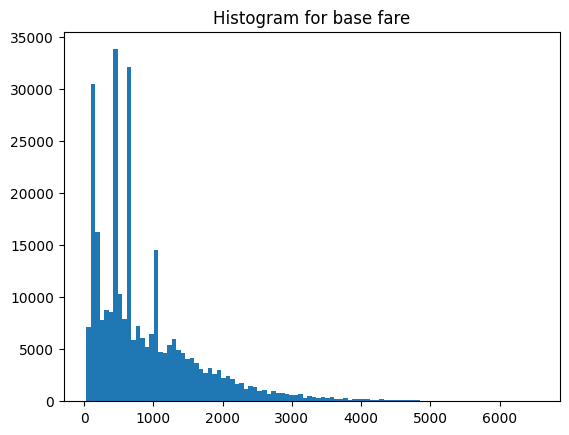

In [71]:
# seems like there are a lot of values and column is independent of class. complex feature
plt.hist(df.baseFare, bins=100)
plt.title("Histogram for base fare")

In [72]:
# ERS NZM DURONTO (12283)
# this train really charges 8375 for Ernakulam to nizam first AC.
df.iloc[[df.baseFare.argmax()]]

,baseFare,reservationCharge,superfastCharge,serviceTax,cateringCharge,dynamicFare,totalFare,availability,trainNumber,timeStamp,fromStnCode,toStnCode,classCode,total_sub_res
56156,6541,60,75,334.0,1365,0,8375,"[{'date': '7-11-2023', 'status': 'GNWL6/WL1'},...",12283,2023-10-30 01:15:53.104962,ERS,NZM,1A,8315


In [73]:
# This also proves that base fare is quite independent of class code and complex. might depend on distance
df.groupby(['trainNumber', 'classCode', 'baseFare'])['totalFare'].count()

trainNumber  classCode  baseFare
1027         2A         1321         9
                        1478         1
                        1516         1
                        1588         1
                        1626         1
                                    ..
22645        SL         815         11
                        825          7
                        835          7
                        845          2
                        855          2
Name: totalFare, Length: 61104, dtype: int64

## Superfast Charge

In [74]:
# for train number 2101, three different class code have different super-fast charges. class code not only determines
# base fare but the superfast charge as well.
df.groupby(['trainNumber','classCode', 'superfastCharge'])['totalFare'].count()

trainNumber  classCode  superfastCharge
1027         2A         0                   81
             3A         0                   81
             SL         0                   81
1065         2S         0                   75
             CC         0                   75
                                          ... 
22644        3A         45                 455
             SL         30                 455
22645        2A         45                 272
             3A         45                 272
             SL         30                 272
Name: totalFare, Length: 1383, dtype: int64

In [75]:
# superfast charge only determined by train number and class code and independent of train travel distance. So can
# easily be precomputed
df[df.trainNumber==2101].groupby(['trainNumber', 'superfastCharge', 'classCode', 'fromStnCode'])['totalFare'].count()

trainNumber  superfastCharge  classCode  fromStnCode
2101         15               2S         DR             5
                                         IGP            4
                                         KYN            5
                                         LS             1
                                         NK             3
                                         NR             2
                                         TNA            5
             30               SL         DR             5
                                         IGP            4
                                         KYN            5
                                         LS             1
                                         NK             3
                                         NR             2
                                         TNA            5
             45               CC         DR             5
                                         IGP            4
                   

In [76]:
df1 = df[df.superfastCharge>0].groupby(['trainNumber','classCode', 'superfastCharge'])['totalFare'].count()
lst = df1.index.to_list()
json.dump(lst, open("../Data/precomputes/superfast_charge.json", 'w'))

In [77]:
df['total_sub_res_sub_sup'] = df.total_sub_res - df.superfastCharge

## Catering Charge

In [78]:
# definitely depends on train arrival and departure as they give food on fixed time periods like lunch, dinner, ...
df[df.cateringCharge>0].groupby(['trainNumber', 'cateringCharge', 'classCode'])['totalFare'].count()

trainNumber  cateringCharge  classCode
12269        65              SL           1
             105             2A           1
                             3A           1
             120             SL           5
             135             SL           2
                                         ..
20912        308             CC           6
22549        35              CC           1
             142             CC           5
22550        242             CC           3
             257             CC           3
Name: totalFare, Length: 450, dtype: int64

In [79]:
# Only 33 trains offer catering. One column can be added if the train offers catering or not
df[df.cateringCharge>0].trainNumber.unique()

array([12269, 12270, 12274, 12278, 12281, 12282, 12283, 12284, 12285,
       12286, 12293, 12294, 12301, 12302, 12305, 12306, 12309, 12310,
       12313, 12314, 20834, 20835, 20836, 20839, 20840, 20897, 20898,
       20901, 20902, 20911, 20912, 22549, 22550], dtype=int64)

In [80]:
lst = df[df.cateringCharge>0].trainNumber.unique().tolist()
json.dump(lst, open("../Data/precomputes/catering_trains.json", 'w'))

In [81]:
df['if_offering_catering'] = df.cateringCharge>0

## Dynamic fare

In [82]:
# as the name says. depends on date for very few trains
# only 26 train offers
df[df.dynamicFare>0].trainNumber.unique()

array([12269, 12270, 12274, 12278, 12281, 12282, 12283, 12284, 12285,
       12286, 12289, 12290, 12293, 12294, 12297, 12298, 12301, 12302,
       12305, 12306, 12309, 12310, 12313, 12314, 20839, 20840],
      dtype=int64)

In [83]:
lst = df[df.dynamicFare>0].trainNumber.unique().tolist()
json.dump(lst, open("../Data/precomputes/dynamicfare_trains.json", 'w'))

In [84]:
df['if_dynamic_fare'] = df.dynamicFare>0

## Preparing data for further analysis

In [85]:
df.head()

,baseFare,reservationCharge,superfastCharge,serviceTax,cateringCharge,dynamicFare,totalFare,availability,trainNumber,timeStamp,fromStnCode,toStnCode,classCode,total_sub_res,total_sub_res_sub_sup,if_offering_catering,if_dynamic_fare
2311,1321,50,0,69.0,0,0,1440,"[{'date': '4-11-2023', 'status': 'NOT AVAILABL...",1027,2023-10-30 00:50:10.756176,DR,NK,2A,1390,1390,False,False
2312,960,40,0,50.0,0,0,1050,"[{'date': '4-11-2023', 'status': 'NOT AVAILABL...",1027,2023-10-30 00:50:10.756176,DR,NK,3A,1010,1010,False,False
2313,365,20,0,0.0,0,0,385,"[{'date': '4-11-2023', 'status': 'NOT AVAILABL...",1027,2023-10-30 00:50:10.756176,DR,NK,SL,365,365,False,False
2314,1321,50,0,69.0,0,0,1440,"[{'date': '4-11-2023', 'status': 'PQWL16/WL11'...",1027,2023-10-30 00:50:10.756176,DR,BSL,2A,1390,1390,False,False
2315,960,40,0,50.0,0,0,1050,"[{'date': '4-11-2023', 'status': 'PQWL28/WL17'...",1027,2023-10-30 00:50:10.756176,DR,BSL,3A,1010,1010,False,False


In [86]:
df1 = df[['trainNumber', 'fromStnCode', 'toStnCode', 'classCode', 'if_offering_catering', 'if_dynamic_fare',
         'total_sub_res_sub_sup']]
df1.rename(columns={'total_sub_res_sub_sup': 'fare_to_predict'}, inplace=True)
df1.to_csv("../Data/processed_data/static_fare_analyzed.csv", index=False)

C:\Users\bhavy\AppData\Local\Temp\ipykernel_5288\4231529205.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename(columns={'total_sub_res_sub_sup': 'fare_to_predict'}, inplace=True)
